In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette('tab10')
import statistics
import numpy as np
# from geopy import geocoders
import pycountry_convert as pc
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn import preprocessing
from sklearn.compose import make_column_selector as selector
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline

## Summary (Steps and Findings)

### Data Prepocessing

We were given with the quality grading data of two different coffee species (Arabica and Robusta). To get the data ready for EDA and some modeling, we have applied the following preprocessing steps right in flow.
 
   1.  <b> Combining both dataset:</b> Arabica dataset was much bigger (1300+ instances) than the Robusta one (only 26 records). Therefore, it was better to combine both of the. Through analyzing some statistical metrics (i.e. central tendencies), we saw that both of the datasets are not that different. Hence, we appended the Robusta dataset with Arabica.
   
   2. <b> Dealing with Missing Values:</b> We notice that there are eight columns with missing values (0.07% to 17%): three columns with continuous (float) values, four categorical columns, and one integer column. We followed a univariate based missing values imputation using the mean/mode of the column within the ('country_of_origin', 'species') group.
   
   3. <b> Selecting important features:</b> In order to find relevant features, we computed correlation between target variable (quality_score) and other numerical features. We inferred that columns ('quality_score', 'aroma', 'flavor', 'aftertaste', 'acidity', 'body', 'balance', 'clean_cup', 'sweetness', 'cupper_points') are highly correlated with the quality_score, while columns ('moisture', 'category_one_defects', 'category_two_defects') are negatively correlated with our target feature quality_score. We kept both of these sets and dropped other numerical columns
   
   4. <b> Adding new column: </b> As we are particularly interested to do some analysis on regional bases (i.e. Central America). Therefore, we add a new column as 'continent'. Although, Central America is not a separate continent yet we kept it separate just for our analysis.
   
   4. <b> Feature Scaling and Encoding: </b> Most of our numerical features were not on a single scale which might hinder the model to converge fast. Moreover, After feature selection, we are also left with some important categorical columns ('species','country_of_origin','variety','processing_method','color'). We applied MinMaxScaler to scale numeric features and OneHotEncoder to encode the categorical features. However, we used this part of preprocessing in the prediction pipeline defined in the Modeling section.
   
### Exploratory Data Analysis

 We did some EDA, to find the answers to the questions asked,

   1. <b>Understand which factors contribute to a high coffee quality score.</b>
   
   Using the Data Preprocessing and EDA we found the following contributing factors (especially Fig 2, EDA, Fig 3, and regression coefficients)
   
       1. Positive factors: ('quality_score', 'aroma', 'flavor', 'aftertaste', 'acidity', 'body', 'balance', 'clean_cup', 'sweetness', 'cupper_points') with super high to high correlation. While in categorical variable ('continent', 'country_of_origin','variety') are also highly important.
       2. Negative factors: ('moisture', 'category_one_defects', 'category_two_defects') are factors, negatively impact the quality score. Here, 'category_one_defects' and 'category_two_defects' have a medium impact while moisture has a comparatively lower impact.
       https://www.coffeestrategies.com/wp-content/uploads/2020/08/Green-Coffee-Defect-Handbook.pdf
       
   2. <b>Provide a recommendation to a prospective coffee farmer on what to consider to produce a high-quality coffee in Central America.</b>

   A major chunk of the records (~44%) are associated with the Central America region. Here, we can infer that the countries in Central America are the biggest producer of coffee. However, we notice on average Central American countries have a lower quality score. We also notice that mostly in the case of highly correlated features, 'Central America' is performing comparatively poor than other continents and better on the negatively correlated features, especially category_two_defect and moisture. Moreover, we notice that the distribution of values for 'Central America' in each feature is quite wide along with having many outliers. Which indicated a sort of inconsistency in production. 
   
   To find the reasons behind this, there could be three factors behind this: 1) variety, 2) any specific country within the region with poor performance, or 3) processing_method. We investigated this draft our suggestions as
          
        1. The major chunk of production comprises three varieties (Bourban, Typica, and Caturra). We can notice that 'Typica' (holding the second highest chunk) has an inferior score but the highest defect score as compared to the third one 'Catura' and all the varieties in the top 5. So, the first suggestion we can make is to drop Typica or get it least production.
        2. Drop 'Typica' or at least decrease its production as compared to the 'Catura' (which is also best in the rest of the regions). 'Catura' can give them a better score with less defect score. Moreover, we have some examples from the coffees produced in small quantities but people liked them very much. May take look at them if it would worthful to promote them more e.g. 'Gesha'.
        3. We see that about 72% of the production comes from Mexico (41%) and Guatemala (31%). However, Mexico has a slightly lower score than Guatemala but more importantly very high score for negatively correlated features like moisture, category_one_defect, and category_two_defect. 
        4. The main reason behind the Mexican farmers getting lower scores is the variety 'Typica'. We already saw that 'Typica' has more defects and higher moisture level than most of the other which make it a bit less attractive.
        5. The Farmers in Mexico should more focus on reducing the moisture and reducing defects. This will ultimately get them a better quality score.

### Prediction Model

To apply or prediction model, we using the following ingredients and steps

   1. <b>Data:</b> data prepared in the data preprocessing section We just add the feature scaling encoding function here along with the prediction pipeline.
   2. <b>Models: </b> We employed three regression-based model: 1) Linear Regression, 2) Decision Tree Regression, and 3) Random Forest Regression.
   3. <b>Evaluate:</b>
       1. Cross validate: We use five-fold cross-validation to evaluate our models.
       2. Metrics: We use R^2 and Mean Squared Error to evaluate the performance.
   4. <b>Results:</b> Among all the three models, linear regression performed better both in terms of R^2 and Mean Squared Error.
   
<b>Note:</b> I just chose the simple option. However, we can further apply more sophisticated data processing (dealing with outliers or applying power transformations to align data with respect to the normal distribution) or model tuning to get better results.


In [2]:
# gn = geocoders.Google()
# gn.geocode("Mexico")

We are given with a data of two species 'Arabica' and 'Robusta'. Let's load both of them

In [3]:
data_arabica = pd.read_csv('./data/arabica.csv')
data_robusta = pd.read_csv('./data/robusta.csv')

## 1. Data Preprocessing

### Combining both datasets

First let's explore both datasets and see if we can merge them together.

In [4]:
data_arabica.head(3)

,QUALITY_SCORE,SPECIES,OWNER,REGION,COUNTRY_OF_ORIGIN,HARVEST_YEAR,VARIETY,STATUS,PROCESSING_METHOD,AROMA,...,SWEETNESS,CUPPER_POINTS,MOISTURE,QUAKERS,CATEGORY_ONE_DEFECTS,CATEGORY_TWO_DEFECTS,COLOR,ALTITUDE_NUMERIC,ALTITUDE_UOM,GRADING_YEAR
0,43.13,Arabica,Ethiopia Commodity Exchange,NaN,Ethiopia,2010,NaN,Completed,NaN,6.00,...,0.00,6.00,0,0.0,0,0,NaN,NaN,NaN,2010
1,59.83,Arabica,Juan Luis Alvarado Romero,NUEVO ORIENTE ALDEA EL LIMON,Guatemala,2012,Catuai,Completed,Washed_Wet,7.50,...,1.33,6.67,10,0.0,0,4,Green,4650.0,ft,2012
2,63.08,Arabica,"Exportadora Atlantic, S.A.",JALAPA,Nicaragua,2016,Caturra,Completed,Other,7.25,...,6.00,6.17,13,0.0,1,5,Green,1100.0,m,2017


In [5]:
data_arabica.describe()

,QUALITY_SCORE,HARVEST_YEAR,AROMA,FLAVOR,AFTERTASTE,ACIDITY,BODY,BALANCE,CLEAN_CUP,SWEETNESS,CUPPER_POINTS,MOISTURE,QUAKERS,CATEGORY_ONE_DEFECTS,CATEGORY_TWO_DEFECTS,ALTITUDE_NUMERIC,GRADING_YEAR
count,1311.000000,1311.000000,1311.000000,1311.000000,1311.000000,1311.000000,1311.000000,1311.000000,1311.00000,1311.000000,1311.000000,1311.000000,1310.000000,1311.000000,1311.000000,1080.000000,1311.000000
mean,82.148825,2013.469870,7.568383,7.522647,7.402464,7.538360,7.522304,7.522082,9.83312,9.903272,7.502441,8.877193,0.177099,0.426392,3.590389,1635.312963,2013.733791
std,2.893505,1.887799,0.318687,0.344348,0.351181,0.320307,0.296022,0.351696,0.77135,0.530832,0.428989,4.801179,0.840583,1.832415,5.351110,1075.892407,1.938382
min,43.130000,2009.000000,5.080000,6.000000,6.170000,5.250000,5.250000,6.000000,0.00000,0.000000,5.170000,0.000000,0.000000,0.000000,0.000000,0.000000,2010.000000
25%,81.170000,2012.000000,7.420000,7.330000,7.250000,7.330000,7.330000,7.330000,10.00000,10.000000,7.250000,9.000000,0.000000,0.000000,0.000000,1100.000000,2012.000000
50%,82.500000,2013.000000,7.580000,7.580000,7.420000,7.500000,7.500000,7.500000,10.00000,10.000000,7.500000,11.000000,0.000000,0.000000,2.000000,1400.000000,2014.000000
75%,83.670000,2015.000000,7.750000,7.750000,7.580000,7.750000,7.670000,7.750000,10.00000,10.000000,7.750000,12.000000,0.000000,0.000000,4.000000,1750.000000,2015.000000
max,90.580000,2018.000000,8.750000,8.830000,8.670000,8.750000,8.580000,8.750000,10.00000,10.000000,10.000000,28.000000,11.000000,31.000000,55.000000,11000.000000,2018.000000


In [6]:
data_arabica.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1311 entries, 0 to 1310
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   QUALITY_SCORE         1311 non-null   float64
 1   SPECIES               1311 non-null   object 
 2   OWNER                 1304 non-null   object 
 3   REGION                1253 non-null   object 
 4   COUNTRY_OF_ORIGIN     1311 non-null   object 
 5   HARVEST_YEAR          1311 non-null   int64  
 6   VARIETY               1109 non-null   object 
 7   STATUS                1311 non-null   object 
 8   PROCESSING_METHOD     1159 non-null   object 
 9   AROMA                 1311 non-null   float64
 10  FLAVOR                1311 non-null   float64
 11  AFTERTASTE            1311 non-null   float64
 12  ACIDITY               1311 non-null   float64
 13  BODY                  1311 non-null   float64
 14  BALANCE               1311 non-null   float64
 15  CLEAN_CUP            

In [7]:
data_robusta.head(3)

,QUALITY_SCORE,SPECIES,OWNER,REGION,COUNTRY_OF_ORIGIN,HARVEST_YEAR,VARIETY,STATUS,PROCESSING_METHOD,AROMA,...,SWEETNESS,CUPPER_POINTS,MOISTURE,QUAKERS,CATEGORY_ONE_DEFECTS,CATEGORY_TWO_DEFECTS,COLOR,ALTITUDE_NUMERIC,ALTITUDE_UOM,GRADING_YEAR
0,73.75,Robusta,Cafe Politico,NaN,Vietnam,2013,NaN,Completed,Natural_Dry,6.75,...,6.67,7.92,12,0,63,9,None,NaN,NaN,2014
1,75.08,Robusta,Cafe Politico,NaN,India,2013,NaN,Completed,Natural_Dry,7.42,...,7.08,6.92,10,0,20,1,Green,NaN,NaN,2014
2,77.17,Robusta,James Moore,KWANZA NORTE PROVINCE ANGOLA,USA,2014,NaN,Completed,Natural_Dry,7.33,...,7.42,7.17,0,0,0,6,NaN,795.0,m,2014


In [8]:
data_robusta.describe()

,QUALITY_SCORE,HARVEST_YEAR,AROMA,FLAVOR,AFTERTASTE,ACIDITY,BODY,BALANCE,CLEAN_CUP,SWEETNESS,CUPPER_POINTS,MOISTURE,QUAKERS,CATEGORY_ONE_DEFECTS,CATEGORY_TWO_DEFECTS,ALTITUDE_NUMERIC,GRADING_YEAR
count,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.0,28.000000,28.000000,25.000000,28.000000
mean,80.868929,2013.964286,7.702500,7.630714,7.559643,7.657143,7.506786,7.541786,9.928214,7.675714,7.761429,6.571429,0.0,2.964286,1.892857,1377.600000,2014.357143
std,2.441233,1.346660,0.296156,0.303656,0.342469,0.261773,0.725152,0.526076,0.211030,0.317063,0.330507,5.846357,0.0,12.357280,2.601129,833.980216,1.253566
min,73.750000,2012.000000,6.750000,6.670000,6.500000,6.830000,5.080000,5.250000,9.330000,6.670000,6.920000,0.000000,0.0,0.000000,0.000000,40.000000,2012.000000
25%,80.170000,2013.000000,7.580000,7.560000,7.397500,7.560000,7.500000,7.500000,10.000000,7.580000,7.580000,0.000000,0.0,0.000000,0.000000,795.000000,2014.000000
50%,81.500000,2014.000000,7.670000,7.710000,7.670000,7.710000,7.670000,7.670000,10.000000,7.750000,7.830000,10.000000,0.0,0.000000,1.000000,1100.000000,2014.000000
75%,82.520000,2015.000000,7.920000,7.830000,7.770000,7.830000,7.830000,7.830000,10.000000,7.830000,7.920000,12.000000,0.0,0.000000,2.000000,1488.000000,2015.000000
max,83.750000,2017.000000,8.330000,8.080000,7.920000,8.000000,8.250000,8.000000,10.000000,8.420000,8.580000,13.000000,0.0,63.000000,9.000000,3170.000000,2017.000000


In [9]:
data_arabica.describe()

,QUALITY_SCORE,HARVEST_YEAR,AROMA,FLAVOR,AFTERTASTE,ACIDITY,BODY,BALANCE,CLEAN_CUP,SWEETNESS,CUPPER_POINTS,MOISTURE,QUAKERS,CATEGORY_ONE_DEFECTS,CATEGORY_TWO_DEFECTS,ALTITUDE_NUMERIC,GRADING_YEAR
count,1311.000000,1311.000000,1311.000000,1311.000000,1311.000000,1311.000000,1311.000000,1311.000000,1311.00000,1311.000000,1311.000000,1311.000000,1310.000000,1311.000000,1311.000000,1080.000000,1311.000000
mean,82.148825,2013.469870,7.568383,7.522647,7.402464,7.538360,7.522304,7.522082,9.83312,9.903272,7.502441,8.877193,0.177099,0.426392,3.590389,1635.312963,2013.733791
std,2.893505,1.887799,0.318687,0.344348,0.351181,0.320307,0.296022,0.351696,0.77135,0.530832,0.428989,4.801179,0.840583,1.832415,5.351110,1075.892407,1.938382
min,43.130000,2009.000000,5.080000,6.000000,6.170000,5.250000,5.250000,6.000000,0.00000,0.000000,5.170000,0.000000,0.000000,0.000000,0.000000,0.000000,2010.000000
25%,81.170000,2012.000000,7.420000,7.330000,7.250000,7.330000,7.330000,7.330000,10.00000,10.000000,7.250000,9.000000,0.000000,0.000000,0.000000,1100.000000,2012.000000
50%,82.500000,2013.000000,7.580000,7.580000,7.420000,7.500000,7.500000,7.500000,10.00000,10.000000,7.500000,11.000000,0.000000,0.000000,2.000000,1400.000000,2014.000000
75%,83.670000,2015.000000,7.750000,7.750000,7.580000,7.750000,7.670000,7.750000,10.00000,10.000000,7.750000,12.000000,0.000000,0.000000,4.000000,1750.000000,2015.000000
max,90.580000,2018.000000,8.750000,8.830000,8.670000,8.750000,8.580000,8.750000,10.00000,10.000000,10.000000,28.000000,11.000000,31.000000,55.000000,11000.000000,2018.000000


We saw that statistical features of both datasets are not that different. Meanwhile, data_robusta is not that big that we can build that modely solely on that dataset. Let's append(merge at the end) data_robusta with the data_arabica and use that dataset for further analysis

In [10]:
data_robusta = data_robusta[data_arabica.columns]

In [11]:
data = data_arabica.append(data_robusta).reset_index(drop = True)

In [12]:
data.columns = map(str.lower, data.columns)

In [13]:
data.describe()

,quality_score,harvest_year,aroma,flavor,aftertaste,acidity,body,balance,clean_cup,sweetness,cupper_points,moisture,quakers,category_one_defects,category_two_defects,altitude_numeric,grading_year
count,1339.000000,1339.000000,1339.000000,1339.000000,1339.000000,1339.000000,1339.000000,1339.000000,1339.000000,1339.000000,1339.000000,1339.000000,1338.000000,1339.000000,1339.000000,1105.000000,1339.000000
mean,82.122061,2013.480209,7.571187,7.524907,7.405751,7.540844,7.521979,7.522494,9.835108,9.856692,7.507857,8.828977,0.173393,0.479462,3.554892,1629.482353,2013.746826
std,2.889808,1.879045,0.318707,0.343794,0.351597,0.319565,0.310502,0.355941,0.763946,0.616102,0.428672,4.834004,0.832121,2.549683,5.313260,1071.411212,1.928307
min,43.130000,2009.000000,5.080000,6.000000,6.170000,5.250000,5.080000,5.250000,0.000000,0.000000,5.170000,0.000000,0.000000,0.000000,0.000000,0.000000,2010.000000
25%,81.080000,2012.000000,7.420000,7.330000,7.250000,7.330000,7.330000,7.330000,10.000000,10.000000,7.250000,9.000000,0.000000,0.000000,0.000000,1100.000000,2012.000000
50%,82.500000,2013.000000,7.580000,7.580000,7.420000,7.580000,7.500000,7.500000,10.000000,10.000000,7.500000,11.000000,0.000000,0.000000,2.000000,1400.000000,2014.000000
75%,83.670000,2015.000000,7.750000,7.750000,7.580000,7.750000,7.670000,7.750000,10.000000,10.000000,7.750000,12.000000,0.000000,0.000000,4.000000,1750.000000,2015.000000
max,90.580000,2018.000000,8.750000,8.830000,8.670000,8.750000,8.580000,8.750000,10.000000,10.000000,10.000000,28.000000,11.000000,63.000000,55.000000,11000.000000,2018.000000


So we can notice that even after ccombining the data from both the species statistical features dont change much except a few points in some features.

In [14]:
data[data.country_of_origin == 'USA'].region.unique()

array(['CENTRAL AMERICA', 'BERASTAGI', 'ANTIOQUIAURRAO',
       'ANTIOQUIAGIRALDO', 'ANTIOQUIABETULIA', 'ANTIOQUIACAICEDO',
       'KWANZA NORTE PROVINCE ANGOLA', 'CHIKMAGALUR'], dtype=object)

In [15]:
# data = pd.get_dummies(data, columns = ['species'])

### Missing values imputations

Let's check the missing values

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1339 entries, 0 to 1338
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   quality_score         1339 non-null   float64
 1   species               1339 non-null   object 
 2   owner                 1332 non-null   object 
 3   region                1279 non-null   object 
 4   country_of_origin     1339 non-null   object 
 5   harvest_year          1339 non-null   int64  
 6   variety               1112 non-null   object 
 7   status                1339 non-null   object 
 8   processing_method     1169 non-null   object 
 9   aroma                 1339 non-null   float64
 10  flavor                1339 non-null   float64
 11  aftertaste            1339 non-null   float64
 12  acidity               1339 non-null   float64
 13  body                  1339 non-null   float64
 14  balance               1339 non-null   float64
 15  clean_cup            

For the ease of usage get the percentage of missing values in each column

In [17]:
(data.isnull().sum()/data.shape[0])*100

quality_score            0.000000
species                  0.000000
owner                    0.522778
region                   4.480956
country_of_origin        0.000000
harvest_year             0.000000
variety                 16.952950
status                   0.000000
processing_method       12.696042
aroma                    0.000000
flavor                   0.000000
aftertaste               0.000000
acidity                  0.000000
body                     0.000000
balance                  0.000000
clean_cup                0.000000
sweetness                0.000000
cupper_points            0.000000
moisture                 0.000000
quakers                  0.074683
category_one_defects     0.000000
category_two_defects     0.000000
color                   16.355489
altitude_numeric        17.475728
altitude_uom            17.251680
grading_year             0.000000
dtype: float64

We notice that there are eight columns with missing values (0.07% to 17%): three columns with continous (float) values, four categorical columns, and one is integer column. We might not need some of these columns at the end, yet first deal with the missing values. Dealing with missing values is always depends on the and the ratio of missing values itself. Normally, if a columns has missing values less than 50% then we can try to deal with that. Since, in all of the columns we have missing values less than even 20% so let's impute them.

Well, there three main categories of techinques to deal with the missing values.

   1. Univariate
   2. Hybrid
   3. Multivariate
   
In univariate, we normally impute the missing values using central tendency based metrics, for instance, Mean or Median (in case of numeric columns) and Mode (in case of categorical columns).

Hybrid is a simple group based univariate imputation. Make groups (using group by) within the data and apply univariate imputation within that. 

In case of multivariate we can use advance or more sophisticated techniques like KNNImputer, Iterative Imputer etc.

Here, we will use the Hybrid approach to impute to missing values.  

We can divide the whole data based on two main groups 'species' and 'country_of_origin'. Therefore, let's make these groups and use the missing values imputer within that group

In [18]:
#data.groupby(by=['country_of_origin','species']).count()

In [19]:
data = data.fillna(np.nan)

In [20]:
missing_columns = data.columns[data.isnull().any()].tolist()

In [21]:
data[missing_columns].isnull().sum()

owner                  7
region                60
variety              227
processing_method    170
quakers                1
color                219
altitude_numeric     234
altitude_uom         231
dtype: int64

Let's deal each column one-by-one and fill the missing values in three steps.

- First, we will fill the missing values with mean/mode of the colum within ['country_of_origin','species'] group. 
- If we are still left with the missing values then we fill those only with ['country_of_origin'] group.
- If we are still left then we can drop those records.

In [22]:
def fill_missing_values_multi_columns(data, missing_columns):
    for col in missing_columns:
        if data[col].dtype=="object":
            data[col].fillna(data.groupby(['country_of_origin','species'])[col].transform(statistics.mode), inplace = True)
#             data[col] = data.groupby(['country_of_origin','species'])[col].transform(lambda x: x.fillna(statistics.mode(x)))
        if data[col].dtype=="int64" or data[col].dtype=='float64':
#             data[col] = data.groupby(['country_of_origin','species'])[col].transform(lambda x: x.fillna(x.mean()))                                                                      
            data[col].fillna(data.groupby(['country_of_origin','species'])[col].transform('mean'), inplace = True)
#         if data[col].dtype=='float':
#             data[col] = imp.fit_transform(data[col].values.reshape(-1,1))
    return data

def fill_missing_values_single_column(data, missing_columns):
    for col in missing_columns:
         if data[col].dtype=="object":
#             data[col].fillna(data.groupby(['country_of_origin','species'])[col].transform(statistics.mode), inplace = True)
            data[col] = data.groupby(['country_of_origin'])[col].transform(lambda x: x.fillna(statistics.mode(x)))
         if data[col].dtype=="int64" or data[col].dtype=='float64':
            data[col] = data.groupby(['country_of_origin'])[col].transform(lambda x: x.fillna(x.mean()))                                                                      
            #combi[col].fillna(combi[col].mode()[0], inplace=True)
#              data[col].fillna(data.groupby(['country_of_origin','species'])[col].transform(statistics.median), inplace = True)
#         if data[col].dtype=='float':
#             data[col] = imp.fit_transform(data[col].values.reshape(-1,1))
    return data

In [23]:
data = fill_missing_values_multi_columns(data.copy(), missing_columns)

In [24]:
data[missing_columns].isnull().sum()

owner                 0
region                4
variety              86
processing_method    40
quakers               0
color                80
altitude_numeric      2
altitude_uom         81
dtype: int64

We saw that even after imputing based 'country_of_origin' and 'species' still we are left with missing values. Let's check that scenario with couple of columns

Let's do another iteration

In [25]:
data = fill_missing_values_multi_columns(data.copy(), missing_columns)

In [26]:
data[missing_columns].isnull().sum()

owner                 0
region                1
variety              20
processing_method    14
quakers               0
color                 9
altitude_numeric      2
altitude_uom          2
dtype: int64

We notice that within that species all the values are null for region column of that country of origin. 

In [27]:
data = fill_missing_values_single_column(data.copy(), missing_columns)

In [28]:
data[missing_columns].isnull().sum()

owner                0
region               0
variety              7
processing_method    2
quakers              0
color                9
altitude_numeric     0
altitude_uom         0
dtype: int64

In [29]:
# data[data.isnull().any(axis=1)]

In [30]:
data = data.dropna()
data.reset_index(drop = True, inplace = True)

In [31]:
data[missing_columns].isnull().sum()

owner                0
region               0
variety              0
processing_method    0
quakers              0
color                0
altitude_numeric     0
altitude_uom         0
dtype: int64

### Feature Selection and Transformation

We cannot use all of the given feature columns for our final modelling. By looking at the data we can simply drop some of the columns (e.g. status, owner). Let's drop these columns first.

In [32]:
data['status'].unique()

array(['Completed'], dtype=object)

status value remains constant

In [33]:
data['owner'].nunique()

312

With an abstract level thinking we can surely say that these columns wont be helpul for the rest of the analysis. Let's drop them here.

In [34]:
data = data.drop(columns=['status','owner'])

In [35]:
data.head(3)

,quality_score,species,region,country_of_origin,harvest_year,variety,processing_method,aroma,flavor,aftertaste,...,sweetness,cupper_points,moisture,quakers,category_one_defects,category_two_defects,color,altitude_numeric,altitude_uom,grading_year
0,43.13,Arabica,SIDAMO,Ethiopia,2010,Other,Natural_Dry,6.00,6.00,6.25,...,0.00,6.00,0,0.0,0,0,Green,1852.112903,m,2010
1,59.83,Arabica,NUEVO ORIENTE ALDEA EL LIMON,Guatemala,2012,Catuai,Washed_Wet,7.50,6.67,6.67,...,1.33,6.67,10,0.0,0,4,Green,4650.000000,ft,2012
2,63.08,Arabica,JALAPA,Nicaragua,2016,Caturra,Other,7.25,6.58,6.33,...,6.00,6.17,13,0.0,1,5,Green,1100.000000,m,2017


 Lets evaluate rest of feature columns and see if we can drop that or no. 

In [36]:
data[data.country_of_origin == 'India'].region.unique()

array(['CHICKMANGALORE', 'CHIKMAGALUR', 'CHIKMAGALUR KARNATAKA',
       'CHIKMAGALUR KARNATAKA INDIA', 'CHIKMAGALUR KARNATAKA INDUA'],
      dtype=object)

In [37]:
data[data.country_of_origin == 'USA'].region.unique()

array(['ANTIOQUIABETULIA', 'CHIKMAGALUR'], dtype=object)

we may find plenty of the cases where region is same but written with incorrect spellings. In another case a region of India 'CHIKMAGALUR' is is given as a region 'USA'. Therefore, we cannot trust this column as well. One option could be to apply some advanced NLP-based techniques to stream line these anomalies. However, its seems we dont need this column for the high level analysis. Let's drop this one as well.

In [38]:
data = data.drop(columns=['region'])

In [39]:
data.head(3)

,quality_score,species,country_of_origin,harvest_year,variety,processing_method,aroma,flavor,aftertaste,acidity,...,sweetness,cupper_points,moisture,quakers,category_one_defects,category_two_defects,color,altitude_numeric,altitude_uom,grading_year
0,43.13,Arabica,Ethiopia,2010,Other,Natural_Dry,6.00,6.00,6.25,6.88,...,0.00,6.00,0,0.0,0,0,Green,1852.112903,m,2010
1,59.83,Arabica,Guatemala,2012,Catuai,Washed_Wet,7.50,6.67,6.67,7.67,...,1.33,6.67,10,0.0,0,4,Green,4650.000000,ft,2012
2,63.08,Arabica,Nicaragua,2016,Caturra,Other,7.25,6.58,6.33,6.25,...,6.00,6.17,13,0.0,1,5,Green,1100.000000,m,2017


In [40]:
data['color'].unique()

array(['Green', 'Blue_Green', 'None', 'Bluish_Green'], dtype=object)

In [41]:
data['variety'].unique()

array(['Other', 'Catuai', 'Caturra', 'Typica', 'Bourbon', 'Mundo Novo',
       'Hawaiian Kona', 'Pacas', 'Pacamara', 'Yellow Bourbon', 'Java',
       'Peaberry', 'SL34', 'Catimor', 'Mandheling', 'Arusha', 'SL28',
       'SL14', 'Gesha', 'Blue Mountain', 'Marigojipe', 'Sumatra',
       'Ruiru 11', 'Sulawesi', 'Ethiopian Heirlooms', 'Moka Peaberry',
       'Ethiopian Yirgacheffe', 'Sumatra Lintong'], dtype=object)

In [42]:
data['processing_method'].unique()

array(['Natural_Dry', 'Washed_Wet', 'Other', 'Semi_washed_Semi_pulped',
       'Pulped_natural_honey'], dtype=object)

So, we are only left with five categorical feature columns (species, country_of_origin, variety, processing_method, color). These columns perhaps would be help to answer the questions given with the challenge and more importantly to build predictive model.

Let's also check if we need time based colums like 'grading_year' or 'harvest_year'?

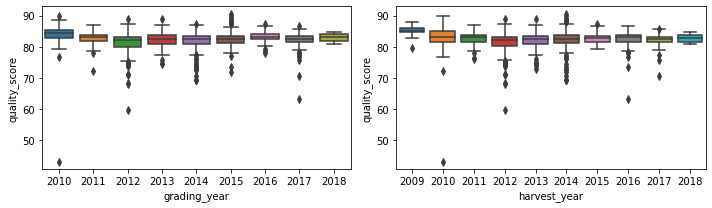

In [43]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3))
axes = axes.ravel()

sns.boxplot(x='grading_year',y='quality_score', data = data , ax = axes[0])
sns.boxplot(x='harvest_year',y='quality_score', data = data , ax = axes[1])

fig.tight_layout()

Since year is also a time based but a numeric featues so we can some put that in correlation matrix as well. Let's see how it would behave

Let's have a look at the non-categorical columns to see if they have any kind of correlation with the target colum

In [44]:
data_num = data.select_dtypes(include=[np.float64, np.int64])#.drop(columns = ['harvest_year','grading_year'])

Let's see we can find something from correlation heatmap

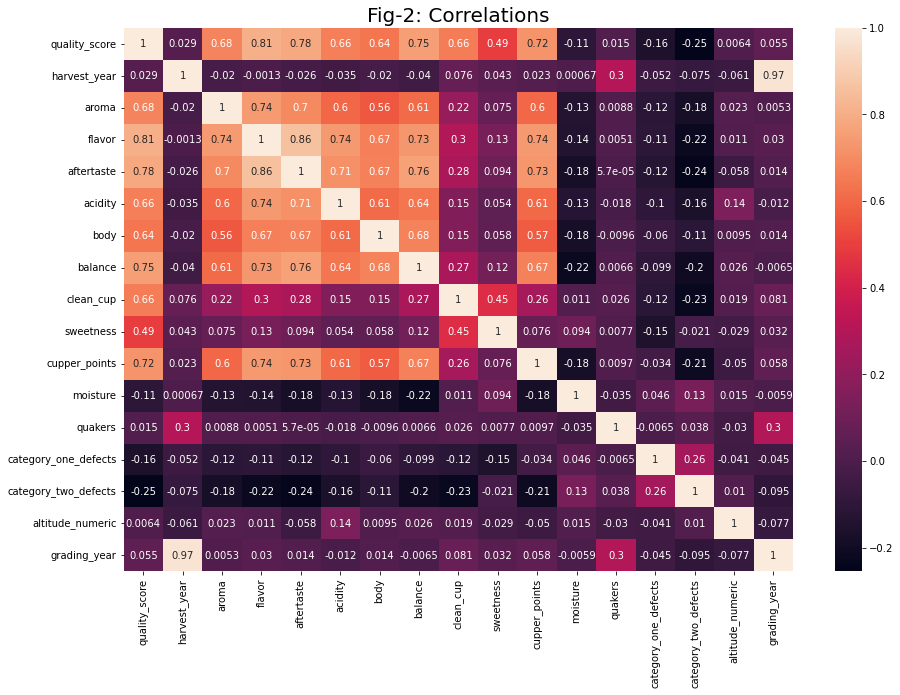

In [45]:
f, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(data_num.corr(), annot=True)
plt.title('Fig-2: Correlations', fontsize = 20)
plt.show()

<b>Inference 1: </b>We can notice columns ('quality_score', 'aroma', 'flavor', 'aftertaste', 'acidity', 'body',
       'balance', 'clean_cup', 'sweetness', 'cupper_points') are highly correlated with the quality_score, columns (
       'quakers',
       'altitude_numeric', 'harvest_year','grading_year') doesnt provide much information regarding the quality_score, while columns ('moisture',
      'category_one_defects', 'category_two_defects') are negatively correlated with our traget feature quality_score. Here, we also notice the higher the defect a coffee has lower the score.

Since ('quakers', 'altitude_numeric') do not provide much information so let's drop them. Let's keep the negatively correlated features for a while. Later on, we will see.

In [46]:
data_num.drop(columns = ['quakers', 'altitude_numeric'], inplace = True)
data.drop(columns = ['quakers', 'altitude_numeric'], inplace = True)

/Users/zaheerbabar/miniforge3/envs/ordechamp/lib/python3.8/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


We will keep the years based features just for the purpose of some analysis. We will drop them just before modeling

In [47]:
data_num.columns

Index(['quality_score', 'harvest_year', 'aroma', 'flavor', 'aftertaste',
       'acidity', 'body', 'balance', 'clean_cup', 'sweetness', 'cupper_points',
       'moisture', 'category_one_defects', 'category_two_defects',
       'grading_year'],
      dtype='object')

### Adding Continent column

last but not the least. since we need to do some analysis based on continent central_america so lets add a column to identify if the country is from central america or not

In [48]:
data['country_of_origin'] = data['country_of_origin'].apply(lambda x: x.split(' ')[0] if x.split(' ')[0] == 'USA' else x)

In [49]:
def country_to_continent(country_name):
    country_alpha2 = pc.country_name_to_country_alpha2(country_name)
    country_continent_code = pc.country_alpha2_to_continent_code(country_alpha2)
    country_continent_name = pc.convert_continent_code_to_continent_name(country_continent_code)
    return country_continent_name

In [50]:
data.country_of_origin.unique()

array(['Ethiopia', 'Guatemala', 'Nicaragua', 'Haiti', 'Mexico',
       'Honduras', 'Brazil', 'Costa Rica', 'USA', 'Colombia',
       'Philippines', 'Indonesia', 'India', 'Peru', 'Taiwan', 'China',
       'El Salvador', 'Thailand', 'Kenya', 'Myanmar', 'Vietnam',
       'Tanzania', 'Malawi', 'Panama', 'Laos', 'Uganda', 'Rwanda',
       'Burundi', 'Japan'], dtype=object)

In [51]:
central_america = ['Mexico','Guatemala','Honduras','Nicaragua','El Salvador','Costa Rica','Panama','Belize']
cont = ['Central America' if country in central_america else country_to_continent(country) for country in data.country_of_origin.tolist()]

In [52]:
data['continent'] = cont

### Feature Scaling and Encoding

We already noticed that distributions of our numeric features are not on a single scale which might hinder the model to converge quickly. Therefore, we have to apply scaling to make to in a single range. We can apply this scaling here or add the scaling and encoding functions in the prediction pipe line. It would be more organized to keep it with the prediction pipeline.

However, if we want to do it here then uncomment the script given belowSo, Let's apply simple features scaling.

Let's first create a copy of data which we will use for modeling. The original copy will be used for EDA.

In [53]:
# transformed_data = data.copy()

# num_cols = list(data.select_dtypes(include=['int64','float64']))
# num_cols.remove('quality_score')
# num_cols.remove('grading_year')
# num_cols.remove('harvest_year')

# scaler = MinMaxScaler()

# transformed_data[num_cols] = scaler.fit_transform(transformed_data[num_cols])

We are not interested to scale target variable or year columns. All the numeric columns exluding target column ('quality_year') and years columns need to be removed.

In case we want to use categorical variable then we have encode them as numeric column but it cant be pure numeric. the best way to encode them is to use label-encoder or one-hot-encoder. It would be more flexible to use that along with the prediction pipeline

In [54]:

# encoders = {}

# transformed_data = data.copy()

# cat_columns =  ['species', 'country_of_origin', 'variety', 'processing_method', 'color','altitude_uom']

# le = preprocessing.LabelEncoder()

# transformed_data[cat_columns] = le.fit_transform(transformed_data[cat_columns])

# for col in cat_columns:
    
#     le = preprocessing.LabelEncoder()
    
#     transformed_data[col] = le.fit_transform(data[col])
    
#     encoders[col] = le

Our transformed data is ready for modeling

## 2. Exploratory Data Analysis

In [55]:
data.head(3)

,quality_score,species,country_of_origin,harvest_year,variety,processing_method,aroma,flavor,aftertaste,acidity,...,clean_cup,sweetness,cupper_points,moisture,category_one_defects,category_two_defects,color,altitude_uom,grading_year,continent
0,43.13,Arabica,Ethiopia,2010,Other,Natural_Dry,6.00,6.00,6.25,6.88,...,0.00,0.00,6.00,0,0,0,Green,m,2010,Africa
1,59.83,Arabica,Guatemala,2012,Catuai,Washed_Wet,7.50,6.67,6.67,7.67,...,1.33,1.33,6.67,10,0,4,Green,ft,2012,Central America
2,63.08,Arabica,Nicaragua,2016,Caturra,Other,7.25,6.58,6.33,6.25,...,6.00,6.00,6.17,13,1,5,Green,m,2017,Central America


We are interested to see formation from the very high level like continent. So, let's start with that.

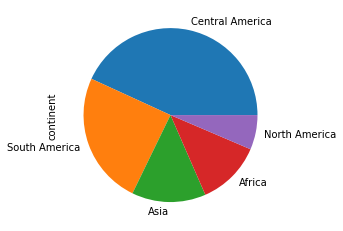

In [56]:
((data['continent'].value_counts()/len(data['continent']))*100).sort_values(ascending = False).plot.pie()#.plot(kind = 'bar')
#plt.ylabel('Percentage')
#plt.xlabel('Continents')
plt.show()

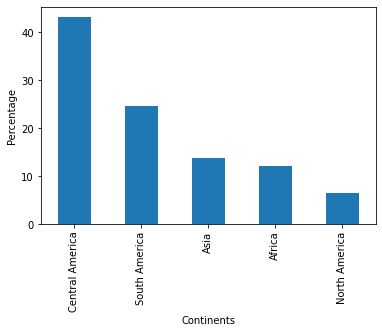

In [57]:
((data['continent'].value_counts()/len(data['continent']))*100).sort_values(ascending = False).plot(kind = 'bar')
plt.ylabel('Percentage')
plt.xlabel('Continents')
plt.show()

We have 45%  of the cases are relevant to the contries in central americal. In other words we can say that these countries have produceed about 45% of the whole production.

Let's the distribution of quality_score wrt to each continent

In [58]:
# data.groupby('continent')['quality_score'].median().reset_index().plot(kind = 'bar')

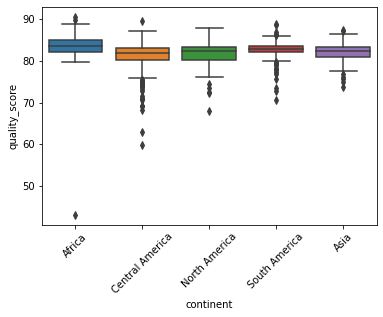

In [59]:
ax = sns.boxplot(x="continent", y="quality_score", data=data)
plt.xticks(rotation = 45)
plt.show()

As per the distribution, we notice that Central America has a wider dsitribution with some outliers. Moreover, it has lower median value than the quality scores from other continents. 

We need to analyze on the core factors behind the quality score. In Fig-1, we already saw that quality_score is highly correlated with ('aroma', 'flavor', 'aftertaste', 'acidity', 'body', 'balance', 'clean_cup', 'sweetness', 'cupper_points') while negatively correlated with columns ('moisture', 'category_one_defects', 'category_two_defects'). So let's visualize and see the the continent wise perfromance wrt to each feature

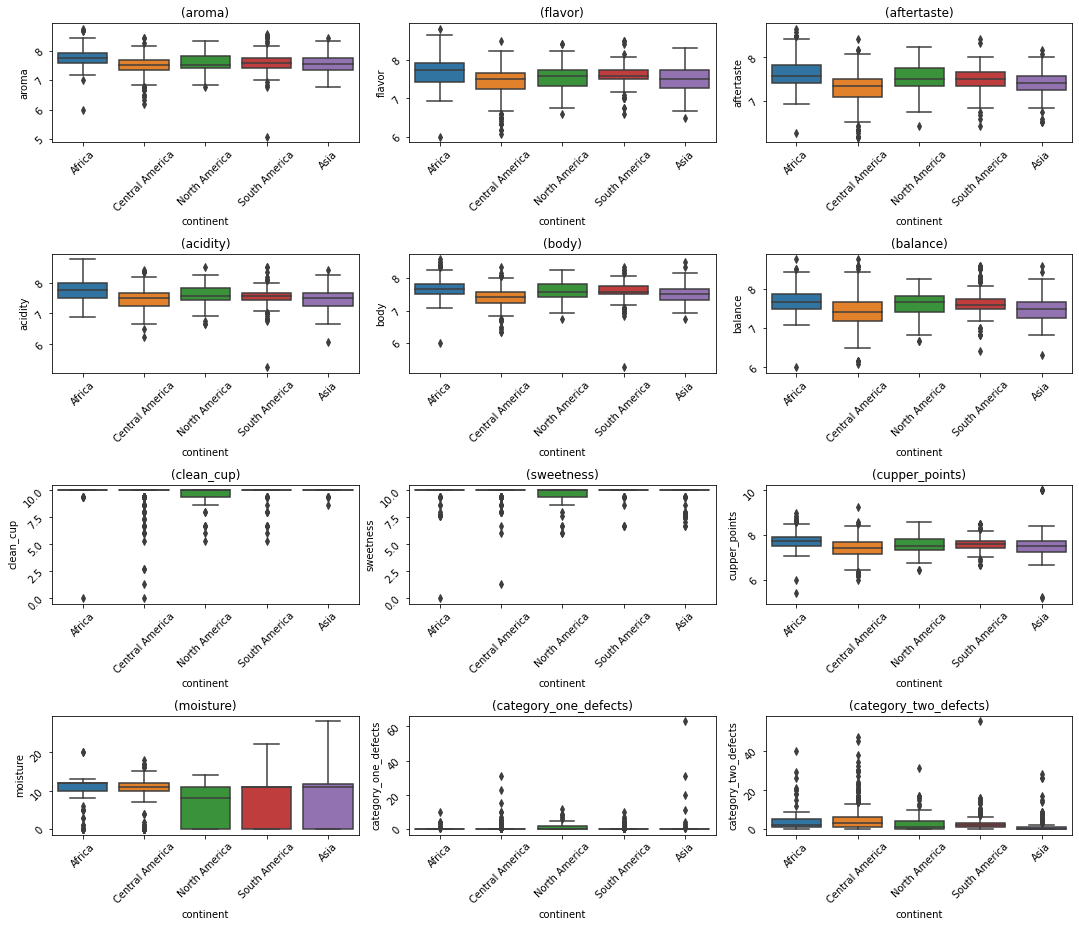

In [60]:
fig, axes = plt.subplots(5, 3, figsize=(15, 15))
axes = axes.ravel()

cols = ['aroma', 'flavor', 'aftertaste',
       'acidity', 'body', 'balance', 'clean_cup', 'sweetness', 'cupper_points',
       'moisture', 'category_one_defects', 'category_two_defects']



for axs, col in zip(axes, cols):
    plot = sns.boxplot(x='continent', y=col, data=data, ax = axs)
    _ = plot.set(title='({})'.format(col))
    axs.tick_params(labelrotation=45)
    plt.xticks(rotation = 45)
axes[-3].set_visible(False)
axes[-2].set_visible(False)
axes[-1].set_visible(False)
#fig.title('month-wise sales distribution of each season', fontsize=16)
fig.tight_layout()



In [61]:
cont_data_agg = data.groupby(['continent'])[['quality_score', 'aroma', 'flavor', 'aftertaste', 'acidity', 'body',
       'balance', 'clean_cup', 'sweetness', 'cupper_points', 'moisture',
       'category_one_defects', 'category_two_defects']].mean().reset_index()

In [62]:
cont_data_agg.sort_values(by='quality_score', ascending = False).style.background_gradient(cmap='Blues')

,continent,quality_score,aroma,flavor,aftertaste,acidity,body,balance,clean_cup,sweetness,cupper_points,moisture,category_one_defects,category_two_defects
0,Africa,83.498176,7.758553,7.711321,7.627233,7.747044,7.678428,7.691950,9.916038,9.746730,7.725094,10.050314,0.169811,3.773585
4,South America,82.792699,7.611043,7.586840,7.487730,7.542362,7.589018,7.634847,9.893620,9.948834,7.595491,7.049080,0.303681,2.668712
1,Asia,82.064725,7.539121,7.499286,7.409231,7.478407,7.509066,7.473187,9.970604,9.761813,7.515165,7.906593,0.752747,1.538462
3,North America,81.523059,7.555529,7.540941,7.479882,7.588471,7.607882,7.604353,9.505647,9.602471,7.554706,5.988235,1.294118,3.305882
2,Central America,81.441909,7.505692,7.436515,7.278844,7.490088,7.435166,7.414168,9.782750,9.910000,7.381103,10.367776,0.467601,4.740806


We notice that mostly in case of highly correlated features, 'Central America' is performing compartively poor than other continents and better on the negatively correlated features especially category_two_defect and moisture. Moreover, another we notice that the distribtion of values for 'Central America' in each feature is quite wide along with having many outliers. Which indicated a sort of inconsistency in production. This inconistency may be due to the variation from different countries in this region. We will see that later on. 

Potentially, there could be three factors behind this: 1) variety, 2) any specific country within region with poor performance, or 3) processing_method. Let's investigate both of these aspects and compare them with rest of the world.

#### Varieties

In [63]:
CA_data = data[data.continent == 'Central America'].reset_index(drop = True)

In [64]:
# CA_data

First let's invetigate the quality of all varieties the framers in Central America producing.

In [65]:
CA_variety_agg = CA_data.groupby('variety')['quality_score'].count().reset_index()#
CA_variety_agg.rename(columns = {'quality_score':'count'}, inplace = True)
CA_variety_agg.sort_values(by = 'count', ascending = False, inplace = True)

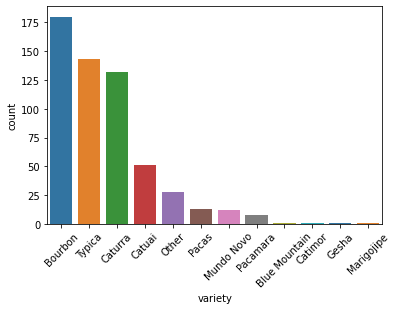

In [66]:
# fig, axes = plt.subplots(1, 2, figsize=(10, 5))
# axes = axes.ravel()

sns.barplot(x='variety', y='count', data=CA_variety_agg, palette = sns.color_palette('tab10'))

# sns.barplot(x='variety', y='mean', data=CA_variety_agg, ax=axes[1], palette = sns.color_palette('tab10'))
# axes[1].tick_params(labelrotation=45)
#fig.tight_layout()
plt.xticks(rotation = 45)
plt.show()

In [67]:
CA_variety_agg_all = CA_data.groupby('variety')[['quality_score', 'aroma', 'flavor', 'aftertaste', 'acidity', 'body',
       'balance', 'clean_cup', 'sweetness', 'cupper_points', 'moisture',
       'category_one_defects', 'category_two_defects']].mean().reset_index()
CA_variety_agg = CA_variety_agg.merge(CA_variety_agg_all, how = 'inner', on = 'variety').sort_values(by = ['count','quality_score'], ascending = False)
CA_variety_agg.style.background_gradient(cmap='Blues')

,variety,count,quality_score,aroma,flavor,aftertaste,acidity,body,balance,clean_cup,sweetness,cupper_points,moisture,category_one_defects,category_two_defects
0,Bourbon,180,81.773056,7.537111,7.473389,7.283333,7.551111,7.480611,7.462667,9.844278,9.910944,7.384944,9.927778,0.216667,3.777778
1,Typica,143,80.828042,7.451678,7.370070,7.229231,7.428811,7.374965,7.325315,9.692238,9.976713,7.310490,11.440559,0.958042,6.832168
2,Caturra,132,82.063561,7.554318,7.490303,7.359091,7.486439,7.474773,7.461742,9.914091,9.944318,7.484015,10.045455,0.424242,3.500000
3,Catuai,51,80.943137,7.501373,7.372353,7.272745,7.502157,7.403725,7.387451,9.673137,9.647059,7.391765,10.196078,0.137255,3.352941
4,Other,28,80.813214,7.425714,7.368571,7.163929,7.398571,7.348214,7.372143,9.761786,9.856786,7.259286,10.035714,0.357143,4.285714
5,Pacas,13,80.910000,7.396923,7.410769,7.232308,7.500000,7.378462,7.391538,9.743846,9.794615,7.320000,9.615385,0.384615,5.846154
6,Mundo Novo,12,79.869167,7.320000,7.311667,7.111667,7.375000,7.326667,7.297500,9.000000,10.000000,7.180000,11.000000,0.583333,14.500000
7,Pacamara,8,82.573750,7.655000,7.688750,7.460000,7.573750,7.500000,7.602500,9.750000,10.000000,7.591250,10.375000,0.750000,5.375000
10,Gesha,1,85.830000,8.000000,8.000000,7.920000,8.080000,7.830000,8.000000,10.000000,10.000000,8.000000,8.000000,0.000000,0.000000
8,Blue Mountain,1,82.670000,7.750000,7.580000,7.250000,7.750000,7.670000,7.580000,10.000000,10.000000,7.080000,0.000000,0.000000,1.000000


The major chunk of production comprises on three varieties (Bourban,Typica, and Caturra). We can notice that 'Typica' holding the second highest chunk has inferior score but highest defect score as compared to the third one 'Catura' and infact all the varieties in top 5. So, first suggestion we can make is to drop Typica or get it least production. 

<b> Inference-2: </b> Drop 'Typica' or at least decrease its production as compared to the 'Catura'. 'Catura' can give them better score with less defect score. Moreover, we have some examples from the coffies produced in small quantities but people liked them very much. May take look at them if it would worthfull to promote them more e.g. 'Gesha'.

Let's see if we can get something by comparing our inference with rest of regions.

In [68]:
data_variety_agg = data.groupby('variety')['quality_score'].count().reset_index()#
data_variety_agg.rename(columns = {'quality_score':'count'}, inplace = True)
data_variety_agg.sort_values(by = 'count', ascending = False, inplace = True)

In [69]:
data_variety_agg_all = data.groupby('variety')[['quality_score', 'aroma', 'flavor', 'aftertaste', 'acidity', 'body',
       'balance', 'clean_cup', 'sweetness', 'cupper_points', 'moisture',
       'category_one_defects', 'category_two_defects']].mean().reset_index()
data_variety_agg = data_variety_agg.merge(data_variety_agg_all, how = 'inner', on = 'variety').sort_values(by = ['count','quality_score'], ascending = False)
data_variety_agg.head(15).style.background_gradient(cmap='Blues')

,variety,count,quality_score,aroma,flavor,aftertaste,acidity,body,balance,clean_cup,sweetness,cupper_points,moisture,category_one_defects,category_two_defects
0,Caturra,343,82.614198,7.589650,7.546006,7.444810,7.534373,7.550262,7.590204,9.928047,9.955248,7.560408,7.962099,0.463557,2.495627
1,Bourbon,255,81.959098,7.558235,7.502510,7.332627,7.548549,7.502078,7.482667,9.832549,9.916196,7.442471,9.596078,0.168627,3.741176
2,Typica,224,81.076652,7.472277,7.387009,7.281027,7.408661,7.397054,7.347411,9.746920,9.934509,7.351830,10.379464,0.678571,4.816964
3,Other,153,82.543856,7.653007,7.613072,7.515882,7.642222,7.617059,7.615948,9.851699,9.607647,7.610065,8.568627,0.888889,3.941176
4,Catuai,74,81.302027,7.491892,7.425405,7.306081,7.494595,7.407703,7.401892,9.765676,9.747703,7.412027,9.594595,0.202703,3.675676
5,Hawaiian Kona,71,81.841127,7.575775,7.588028,7.514507,7.621127,7.630563,7.645775,9.549155,9.642676,7.607606,5.690141,1.422535,3.422535
6,Yellow Bourbon,35,82.430571,7.498000,7.540000,7.404857,7.469143,7.574286,7.569143,9.961714,9.980857,7.604857,5.685714,0.114286,2.342857
7,Mundo Novo,33,81.558485,7.482424,7.492121,7.340909,7.457273,7.477273,7.441818,9.535455,9.979697,7.391212,10.727273,0.363636,7.272727
8,SL14,28,83.265357,7.871429,7.744643,7.631071,7.699643,7.726429,7.661429,10.000000,9.181429,7.750000,11.357143,0.000000,2.000000
9,Catimor,20,83.263000,7.680000,7.650500,7.500000,7.575500,7.597000,7.650500,10.000000,10.000000,7.679000,9.500000,0.000000,1.050000


In [70]:
# data_variety_agg = data.groupby('variety')['quality_score','flavor','aftertaste','balance','cupper_points'].mean().reset_index().sort_values(by = ['quality_score','flavor','aftertaste','balance','cupper_points'], ascending = False)

In [71]:
# data_variety_agg

In [72]:
data_variety_agg = data.groupby('variety')['quality_score'].agg(['mean','count']).reset_index().sort_values(by = 'count', ascending = False)

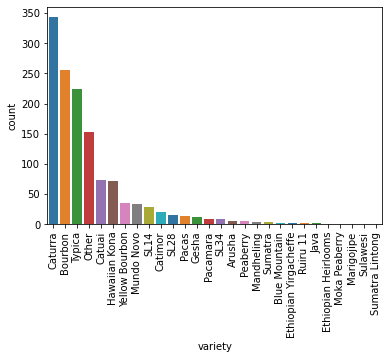

In [73]:
sns.barplot(x='variety', y='count', data=data_variety_agg, palette = sns.color_palette('tab10'))
plt.xticks(rotation = 90)
plt.show()

By looking at the other regions we can verify or Inference-2: Increasing the production of 'Catura' and decreasing the 'Typica'. Moreover, try new varaities like 'Gesha' or 'Yellow Bourbon'

##### Countries

In [74]:
CA_country_agg = CA_data.groupby('country_of_origin')['quality_score'].count().reset_index()#
CA_country_agg.rename(columns = {'quality_score':'count'}, inplace = True)
CA_country_agg.sort_values(by = 'count', ascending = False, inplace = True)

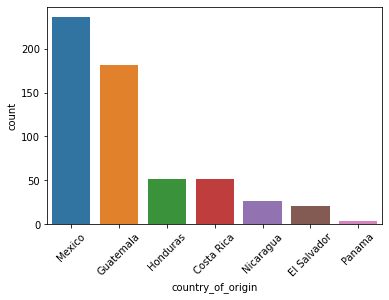

In [75]:
# fig, axes = plt.subplots(1, 2, figsize=(10, 5))
# axes = axes.ravel()

sns.barplot(x='country_of_origin', y='count', data=CA_country_agg, palette = sns.color_palette('tab10'))

# sns.barplot(x='variety', y='mean', data=CA_variety_agg, ax=axes[1], palette = sns.color_palette('tab10'))
# axes[1].tick_params(labelrotation=45)
#fig.tight_layout()
plt.xticks(rotation = 45)
plt.show()

In [76]:
CA_data.shape

(571, 22)

In [77]:
CA_country_agg_all = CA_data.groupby('country_of_origin')[['quality_score', 'aroma', 'flavor', 'aftertaste', 'acidity', 'body',
       'balance', 'clean_cup', 'sweetness', 'cupper_points', 'moisture',
       'category_one_defects', 'category_two_defects']].mean().reset_index()
CA_country_agg = CA_country_agg.merge(CA_country_agg_all, how = 'inner', on = 'country_of_origin').sort_values(by = ['count','quality_score'], ascending = False)
CA_country_agg.style.background_gradient(cmap='Blues')

,country_of_origin,count,quality_score,aroma,flavor,aftertaste,acidity,body,balance,clean_cup,sweetness,cupper_points,moisture,category_one_defects,category_two_defects
0,Mexico,236,80.890085,7.457585,7.379025,7.228051,7.428347,7.380466,7.328686,9.658136,9.971780,7.314703,11.360169,0.843220,6.779661
1,Guatemala,181,81.846575,7.544862,7.489006,7.266851,7.596409,7.475746,7.469890,9.889337,9.870884,7.391105,10.226519,0.187845,3.419890
2,Honduras,52,80.883654,7.432692,7.373269,7.197308,7.372692,7.378462,7.301731,9.820577,9.846154,7.327885,10.750000,0.057692,3.596154
3,Costa Rica,51,82.789020,7.671373,7.537255,7.534510,7.573922,7.537451,7.637255,9.869216,9.908431,7.663529,8.333333,0.352941,2.823529
4,Nicaragua,26,80.458077,7.329231,7.316923,7.201923,7.266538,7.400769,7.278462,9.769231,9.820385,7.278846,10.769231,0.269231,2.769231
5,El Salvador,21,83.052857,7.674762,7.654286,7.567143,7.590476,7.606667,7.711429,9.936190,9.808571,7.563333,4.571429,0.142857,3.571429
6,Panama,4,83.707500,7.667500,7.625000,7.605000,7.705000,7.582500,7.875000,10.000000,10.000000,7.645000,7.000000,0.750000,2.500000


We see that about 72% of the production comes from Mexico (41%) and Guatemala (31%). However, Mexico has slighty lower score than Guatemala but more importanly very high score for negative correllated features like moisture, category_one_defect, and category_two_defect. The Farmers in Mexico should more focus on to reduce the moisture and reduce the defects. This will ultimately get them better quality score.

In [78]:
Mexico_variety = CA_data[CA_data.country_of_origin == 'Mexico']['variety'].value_counts().reset_index()

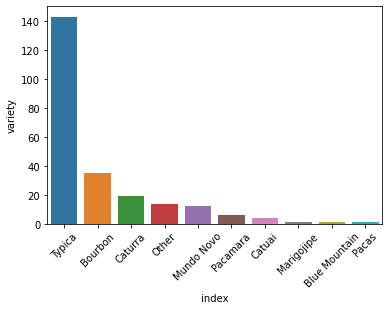

In [79]:
sns.barplot(x='index',y='variety', data = Mexico_variety)
plt.xticks(rotation = 45)
plt.show()

The main reason behind the Mexico farmers getting lower scores is the variety 'Typica'. We already saw that 'Typica' has more defects and higher moisture level than most of the other which makes it bit less attractive.

In [80]:
# fig, axes = plt.subplots(5, 3, figsize=(15, 10))
# axes = axes.ravel()

# cols = ['quality_score', 'aroma', 'flavor', 'aftertaste',
#        'acidity', 'body', 'balance', 'clean_cup', 'sweetness', 'cupper_points',
#        'moisture', 'category_one_defects', 'category_two_defects']



# for axs, col in zip(axes, cols):
#     plot = sns.barplot(x='continent', y=col, data=cont_data_agg, ax = axs)
#     _ = plot.set(title='({})'.format(col))
# axes[-2].set_visible(False)
# axes[-1].set_visible(False)
# #fig.title('month-wise sales distribution of each season', fontsize=16)
# fig.tight_layout()



In [81]:
CA_data[CA_data.country_of_origin == 'Mexico']['processing_method'].value_counts()

Washed_Wet                 205
Natural_Dry                 17
Semi_washed_Semi_pulped     14
Name: processing_method, dtype: int64

In [82]:
CA_data[CA_data.country_of_origin == 'Guatemala']['processing_method'].value_counts()

Washed_Wet     169
Natural_Dry     10
Other            2
Name: processing_method, dtype: int64

In [83]:
data[data.continent == 'Central America']['processing_method'].value_counts()

Washed_Wet                 499
Natural_Dry                 47
Semi_washed_Semi_pulped     16
Other                        7
Pulped_natural_honey         2
Name: processing_method, dtype: int64

In [84]:
data['processing_method'].value_counts()

Washed_Wet                 909
Natural_Dry                319
Semi_washed_Semi_pulped     56
Other                       25
Pulped_natural_honey        14
Name: processing_method, dtype: int64

In [85]:
data[data.continent == 'Central America']['variety'].value_counts()

Bourbon          180
Typica           143
Caturra          132
Catuai            51
Other             28
Pacas             13
Mundo Novo        12
Pacamara           8
Marigojipe         1
Catimor            1
Blue Mountain      1
Gesha              1
Name: variety, dtype: int64

In [86]:
data[data.continent == 'Africa']['variety'].value_counts()

Other                    71
SL14                     28
SL28                     16
Bourbon                  14
Gesha                    11
SL34                      8
Caturra                   3
Ruiru 11                  2
Ethiopian Yirgacheffe     2
Arusha                    1
Ethiopian Heirlooms       1
Peaberry                  1
Typica                    1
Name: variety, dtype: int64

Let's transform these features to find the relationship with out dependent feature (quality_score)

## 3. Modeling

Since records for both species are clustered togther so let's shuffle the data and seperate the data and target variable

In [87]:
data = data.sample(frac=1).reset_index(drop=True)

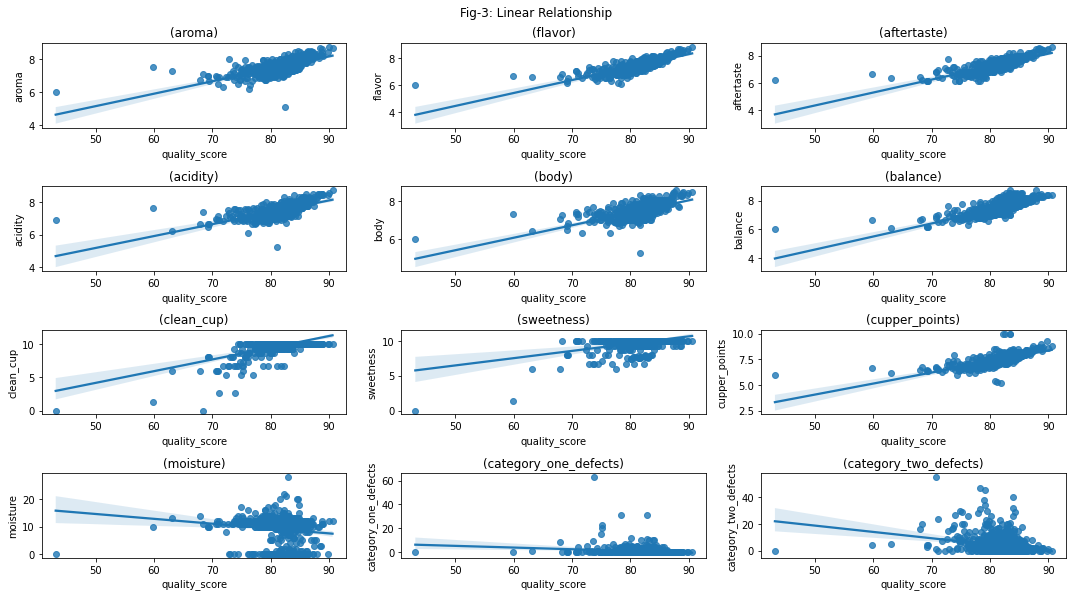

In [88]:
fig, axes = plt.subplots(5, 3, figsize=(15, 10))
axes = axes.ravel()


cols = ['aroma', 'flavor', 'aftertaste',
       'acidity', 'body', 'balance', 'clean_cup', 'sweetness', 'cupper_points',
       'moisture', 'category_one_defects', 'category_two_defects']


for axs, col in zip(axes, cols):
    plot = sns.regplot(x='quality_score', y=col, data=data, ax = axs)
    _ = plot.set(title='({})'.format(col))
axes[-3].set_visible(False)
axes[-2].set_visible(False)
axes[-1].set_visible(False)
fig.suptitle('Fig-3: Linear Relationship')
fig.tight_layout()

In [89]:
X = data.drop(columns=['quality_score'])
Y = data['quality_score']

### Feature scaling and encoding processor

Instead doing features scaling in the preprocessing phase, we opted to keep it more simple and put that along the prediction pipeline

In [90]:
numerical_columns_selector = selector(dtype_exclude=object)
categorical_columns_selector = selector(dtype_include=object)

In [91]:
numerical_columns = numerical_columns_selector(X)
categorical_columns = categorical_columns_selector(X)

In [92]:
numerical_columns

['harvest_year',
 'aroma',
 'flavor',
 'aftertaste',
 'acidity',
 'body',
 'balance',
 'clean_cup',
 'sweetness',
 'cupper_points',
 'moisture',
 'category_one_defects',
 'category_two_defects',
 'grading_year']

In [93]:
numerical_columns.remove('grading_year')
numerical_columns.remove('harvest_year')

In [94]:
categorical_columns.remove('altitude_uom')
categorical_columns.remove('continent')

We would like to check what would be the performance of model by including or exlcluding the important categorical features. Therefore, first we define the pipeline with categorical features and then later on we will train the model only uisng numeric variable.

In [95]:
categorical_preprocessor = OneHotEncoder(handle_unknown="ignore")
numerical_preprocessor = MinMaxScaler()

In [96]:
comb_preprocessor = ColumnTransformer([
    ('one-hot-encoder', categorical_preprocessor, categorical_columns),
    ('minmax_scaler', numerical_preprocessor, numerical_columns)])

### Prediction Pipeline

In [97]:
linear_model = make_pipeline(comb_preprocessor, LinearRegression())
tree_model = make_pipeline(comb_preprocessor, DecisionTreeRegressor())
forest_model = make_pipeline(comb_preprocessor, RandomForestRegressor(random_state=0))

In [98]:
# X = transformed_data.drop(columns=['quality_score','continent','harvest_year','grading_year','species', 'country_of_origin', 'variety', 'processing_method', 'color','altitude_uom'])
# Y = transformed_data['quality_score']

#### Evaluation

In [99]:
scores = cross_validate(linear_model, X, Y, cv=5, scoring=['r2','neg_mean_squared_error'])
scores

{'fit_time': array([0.01143408, 0.01049685, 0.01089525, 0.01133418, 0.01003695]),
 'score_time': array([0.00335479, 0.00259399, 0.00265384, 0.00234985, 0.00240016]),
 'test_r2': array([0.97465795, 0.96031322, 0.9789351 , 0.95696528, 0.97387849]),
 'test_neg_mean_squared_error': array([-0.20630452, -0.23592893, -0.24655221, -0.26397511, -0.24586338])}

In [100]:
scores = cross_validate(tree_model, X, Y, cv=5, scoring=['r2','neg_mean_squared_error'])
scores

{'fit_time': array([0.01605701, 0.01435208, 0.01378012, 0.01392794, 0.01364183]),
 'score_time': array([0.00273418, 0.00262523, 0.00235105, 0.00210595, 0.00211811]),
 'test_r2': array([0.8905347 , 0.8717908 , 0.80583369, 0.83936641, 0.52169212]),
 'test_neg_mean_squared_error': array([-0.89113509, -0.76217472, -2.27260151, -0.98532689, -4.50197462])}

In [101]:
scores = cross_validate(forest_model, X, Y, cv=5, scoring=['r2','neg_root_mean_squared_error'])
scores

{'fit_time': array([0.66108894, 0.65299487, 0.65049219, 0.65514493, 0.65544915]),
 'score_time': array([0.00863504, 0.00866389, 0.00841284, 0.00876522, 0.00847888]),
 'test_r2': array([0.93529062, 0.94257191, 0.80854566, 0.93319333, 0.88324506]),
 'test_neg_root_mean_squared_error': array([-0.72580031, -0.58429188, -1.49695005, -0.64015023, -1.04829951])}

<b> Only numeric features: </b> Now let's use only numeric features (identified using the Fig-2) to fit our model and see how it behaves.

In [102]:
preprocessor = ColumnTransformer([('minmax_scaler', numerical_preprocessor, numerical_columns)])

In [103]:
linear_model = make_pipeline(preprocessor, LinearRegression())
tree_model = make_pipeline(comb_preprocessor, DecisionTreeRegressor())
forest_model = make_pipeline(preprocessor, RandomForestRegressor(random_state=0))

In [104]:
scores = cross_validate(linear_model, X[numerical_columns], Y, cv=5, scoring=['r2','neg_root_mean_squared_error'])
scores

{'fit_time': array([0.00258207, 0.0019269 , 0.00178099, 0.00183415, 0.00199389]),
 'score_time': array([0.00198293, 0.00094628, 0.00096297, 0.00110102, 0.0010612 ]),
 'test_r2': array([0.97160883, 0.96410965, 0.9775001 , 0.95757749, 0.9754682 ]),
 'test_neg_root_mean_squared_error': array([-0.48075654, -0.46190908, -0.51317441, -0.51011745, -0.48052109])}

In [105]:
scores = cross_validate(forest_model, X[numerical_columns], Y, cv=5, scoring=['r2','neg_root_mean_squared_error'])
scores

{'fit_time': array([0.22457385, 0.21363807, 0.21122718, 0.2303679 , 0.23383999]),
 'score_time': array([0.00613189, 0.00595403, 0.00576305, 0.00742602, 0.0064621 ]),
 'test_r2': array([0.93968274, 0.943171  , 0.82593237, 0.93594917, 0.93219   ]),
 'test_neg_root_mean_squared_error': array([-0.70073582, -0.58123622, -1.42736062, -0.62680776, -0.79890406])}

### Result

Finally, we saw the linear regression (with both categorical and numerical features) has performed best among all the regression based model. 

In [106]:
# X_train, X_test, y_train, y_test = train_test_split(
# ...     X, Y, test_size=0.20, random_state=42)
# lr = LinearRegression().fit(X_train[numerical_columns], y_train)
# lr.score(X_train[numerical_columns], y_train)
# numerical_columns

In [107]:
# lr.coef_